* **Práctica 1: Introducción a la segmentación semántica: preprocesado, métricas e inferencia.**
* **Práctica 2: Implementación y entrenamiento de redes UNET para un problema binario (dataset carvana)**
* **Práctica 3: Implementación y entrenamiento de redes FCN para un problema multiclase (dataset cityscapes)**

In [1]:
# Montar el directorio que contiene los datos (IMPORTANTE: antes añadir la carpeta compartida a nuestro Drive!!)
# Comentar este bloque si la ejecución es en local
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
main_path = "/content/drive/MyDrive/Segmentation/Practica 3"

In [5]:
from PIL import Image
import shutil
import torch
import torchvision
from PIL import Image
import os
import numpy as np
#import tensorflow as tf
import random
import torch
from torch import nn
from torch.nn import functional as F
import albumentations as A
from albumentations.pytorch import ToTensorV2
import tqdm
from time import time
import json
from matplotlib import pyplot as plt
#import torchmetrics
torch_to_pil = torchvision.transforms.ToPILImage()

In [6]:
os.listdir(main_path)

['model_graph.png',
 'callbacks.py',
 'dataset.py',
 'firstClean.ipynb',
 'utils.py',
 'dataset',
 'models',
 'models.py',
 'trainFCNs.ipynb']

# **Introducción a la segmentación semántica en PyTorch - Práctica 3: Implementación y entrenamiento de arquitecturas FCN sobre el dataset cityscapes**

## **Máster IA3: Aprendizaje Profundo II**

### *Antonio Martínez González* (antonio.martinez-gonzalez@uv.es)


A lo largo de este documento implementaremos la resolución de un poblema de segmentación semántica multiclase mediante arquitecturas FCN (*Fully Convolutional Networks*), pasando por todas las etapas.

Para ello se utilizará el dataset [cityscapes](https://www.cityscapes-dataset.com/dataset-overview/), compuesto por imágenes adquiridas en entornos urbanos.

![cityscapes.png](attachment:cityscapes.png)

# **Introducción**



[Cityscapes](https://www.cityscapes-dataset.com/dataset-overview/) es una base de datos de gran escala muy utilizada en el campo de la segmentación de imágenes aplicada a la comprensión de escenas urbanas.

Contiene información detallada a varios niveles:
* Nivel semántico: etiqueta en cada pixel
* Por instancias: identificador a cada instancia
* Poligonos
* etc

Está compuesto por 30 clases, agrupadas en 8 categorías:

* **flat**:	road, sidewalk, parking, rail track
* **human**: person, rider
* **vehicle**: car, truck, bus, on rails, motorcycle, bicycle, caravan, trailer
* **construction**: building, wall, fence, guard rail, bridge, tunnel
* **object**: pole, pole group, traffic sign, traffic light
* **nature**: vegetationterrain
* **sky**: sky
* **void**: ground, dynamic, static

A lo largo de esta tercera práctica nos centraremos en la segmentación semántica del dataset. Nuestro objetivo consiste por lo tanto en asignar una única etiqueta a cada uno de los pixeles que componen la imágen de entrada. Al contrario que en la praćtica anterior, nos encontramos ante un problema multiclase (*pixel by pixel multiclass classification*) y ante imágenes con una complejidad significativamente superior.

Dicho esto, de las 30 clases inciales nos quedaremos con 20 (19 objetos de interés mas la clase de referencia o *backround*), siguiendo las indicaciones del [repositorio](https://github.com/mcordts/cityscapesScripts) oficial de Github asociado al dataset. En las instrucciones de la plataforma de benchmarking del dataset cityscapes para el problema de la segmentación semántica se menciona explícitamente que las clases que hemos descartado no son consideradas en el proceso de evaluación.

La siguiente celda construye el mapeado entre el índice original de cada clase y el nuevo índice tras el descarte de las clases redundantes. Notar como todas las clases innecesarias son agrupadas en el índice 0.

In [8]:
# mapeado old_class_index:new_class_index
new_ids = {
    0 : 0,
    1 : 0,
    2 : 0,
    3 : 0,
    4 : 0,
    5 : 0,
    6 : 0,
    7 : 1,
    8 : 2,
    9 : 0,
    10 : 0,
    11 : 3,
    12 : 4,
    13 : 5,
    14 : 0,
    15 : 0,
    16 : 0,
    17 : 6,
    18 : 0,
    19 : 7,
    20 : 8,
    21 : 9,
    22 : 10,
    23 : 11,
    24 : 12,
    25 : 13,
    26 : 14,
    27 : 15,
    28 : 16,
    29 : 0,
    30 : 0,
    31 : 17,
    32 : 18,
    33 : 19,
    -1 : 0,
}

El diccionario new_ids será principalmente utilizado para reasignar los índices de las clases en las máscaras ground truth del dataset durante la etapa de importación y preprocesado de los datos.

La siguiente celda construye el mapeado que asocia el nuevo índice de cada clase a su triplete RGB correspondiente, con el objetivo de disponer de una visualización estandarizada con el mapa de colores oficial de cityscapes.

La información necesaria para construir ambos diccionarios ha sido extraida del siguiente [enlace](https://github.com/mcordts/cityscapesScripts/blob/master/cityscapesscripts/helpers/labels.py). En concreto a partir de la lista *labels* que se define en el script del enlace.

In [9]:
COLORMAP = {
    0 : [0,0,0],
    1 : [128,64,128],
    2 : [244,35,232],
    3 : [70,70,70],
    4 : [102,102,156],
    5 : [190,153,153],
    6 : [153,153,153],
    7 : [250,170,30],
    8 : [220,220,0],
    9 : [107,142,35],
    10 : [152,251,152],
    11 : [70,130,180],
    12 : [220,20,60],
    13 : [255,0,0],
    14 : [0,0,142],
    15 : [0,0,70],
    16 : [0,60,100],
    17 : [0,80,100],
    18 : [0,0,230],
    19 : [119,11,32],
}

In [10]:
def mask_to_rgb(mask, cmap=COLORMAP, contour=None):
    """ Convierte una mascara del dataset PASCAL VOC, donde cada elemento
    contiene el índice de la clase a la que pertenece, en una imágen RGB respetando
    la correspondencia definida en el diccionario VOC_COLORMAP_ """

    if not isinstance(mask, np.ndarray) or not mask.ndim == 2:
      raise ValueError("Input must be an 2D np.array")

    mask_rgb = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8) # Inicializacion a cero

    present_classes = set(np.unique(mask).astype(int))
    if contour in present_classes:
        present_classes.remove(contour)

    for class_index in present_classes:
        mask_rgb[mask == class_index] = cmap[class_index]

    return mask_rgb

# **Importación y preprocesado**

Las etapas de importación y preprocesado de los datos son prácticamente idénticas a lo implementado en la práctica anterior, por lo que nos limitaremos a exportar la clase necesaria con ligeras modificaciones en lo que respecta al formato de las rutas de las imágenes y máscaras.

La reasignación de las clases se ha realizado de forma separada previo a la ejecución de este notebook y se encuentra disponible en el documento *firstClean.ipynb*, además de simplificar el formato original de las rutas de imágenes y máscaras:

* ruta imágen: *code.png*
* ruta máscara: *codecleaned_labels.png*

In [11]:
class cityscapesDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, scale=False, to_torch_tensor=False):
        self.image_dir = image_dir # Ruta del directorio que contiene las imagenes de entrada
        self.mask_dir = mask_dir # Ruta del directorio que contiene las mascaras de salida
        self.codes = [i.replace(".png", "") for i in os.listdir(image_dir)] # Lista que contiene los codigos identificadores de cada imagen
        self.transform = transform
        self.scale = scale
        self.to_torch_tensor = to_torch_tensor

    def __len__(self): # Devuelve el numero de muestras del dataset (una por cada codigo identificador de la imagen)
        return len(self.codes)

    def __getitem__(self, index): # Importación y preprocesado de una muestra
        code = self.codes[index]
        img_path = os.path.join(self.image_dir, code+".png") # Ruta de la imagen de entrada
        mask_path = os.path.join(self.mask_dir, code+"cleaned_labels.png") # Ruta de la mascara
        image = np.array(Image.open(img_path).convert("RGB"), dtype=np.float32)
        mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)
        if self.scale:
            image = image / 255.0
        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
        else:
            image = np.transpose(image, (2,0,1))
            self.to_torch_tensor = True
        if self.to_torch_tensor:
            image = torch.from_numpy(image)
            mask = torch.from_numpy(mask)
        return image, mask

Para este caso se ha optado por mantener las transformaciones de data augmentation introducidas en la práctica anterior y por reducir el tamaño de las imágenes a $500\times1000$ (una reducción mayor tendrá con casi total seguridad consecuencias negativas en el rendimiento de los modelos propuestos dada la complejidad e las imágenes actuales). Aunque existen ciertas transformaciones adicionales que no se han tratado y que han demostrados proporcionar buenos resultados en entornos como el actual:

* Scalling (ayuda a identificar objetos de diferente tamaño y distancia respecto de la cámara)
* Cropping (simplifica la complejidad de las escenas)
* Color jittering (ayuda al modelo a ser invariante frente a cambios de iluminación y color)
* Gaussian blur (simula variaciones en el foco de la cámara y en las condiciones ambientales)

In [12]:
dataset = cityscapesDataset(
    image_dir=os.path.join(main_path, "dataset", "leftImg8bit", "test"),
    mask_dir=os.path.join(main_path, "dataset", "gtFine", "test"),
    transform=A.Compose([
        A.Resize(height=500, width=1000),
        ToTensorV2(),
    ]),
    scale=True)

In [13]:
x, y = dataset.__getitem__(0)

In [14]:
x.shape

torch.Size([3, 500, 1000])

In [15]:
y.shape

torch.Size([500, 1000])

In [16]:
np.unique(y)

array([ 0.,  1.,  2.,  3.,  4.,  6.,  8.,  9., 10., 11., 12., 13., 14.,
       19.], dtype=float32)

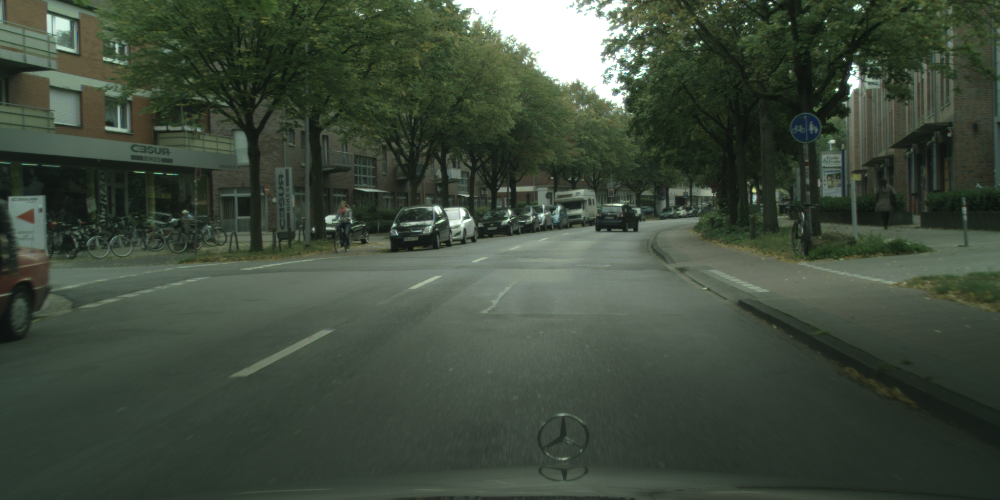

In [17]:
torch_to_pil(x)

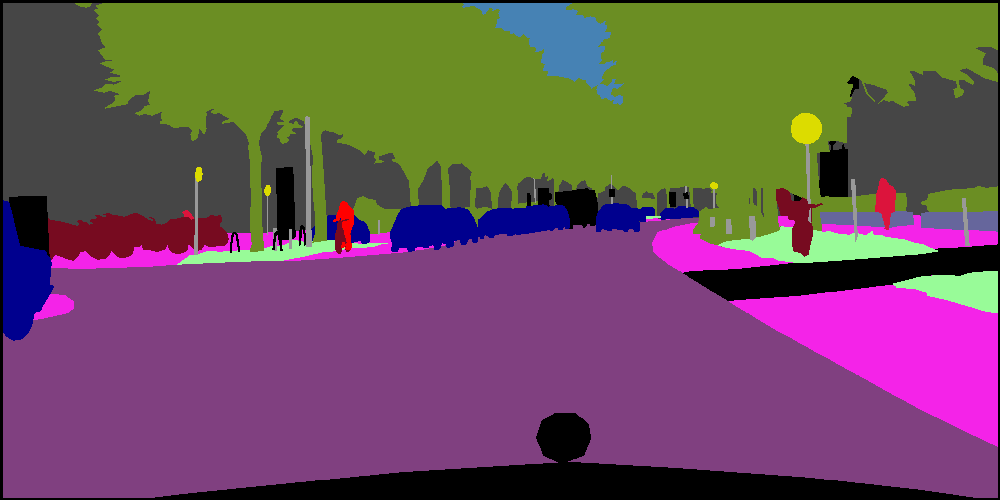

In [18]:
Image.fromarray(mask_to_rgb(y.numpy()))

In [19]:
x, y = dataset.__getitem__(1)

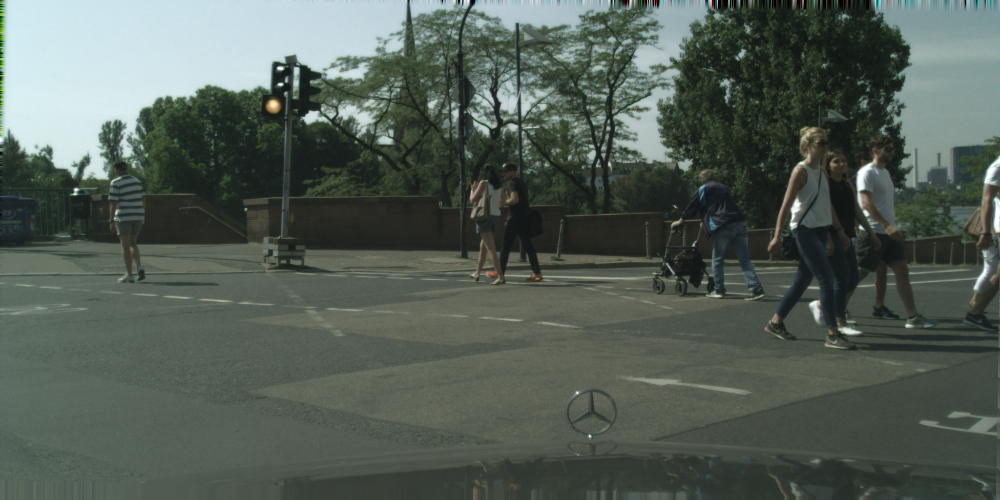

In [20]:
torch_to_pil(x)

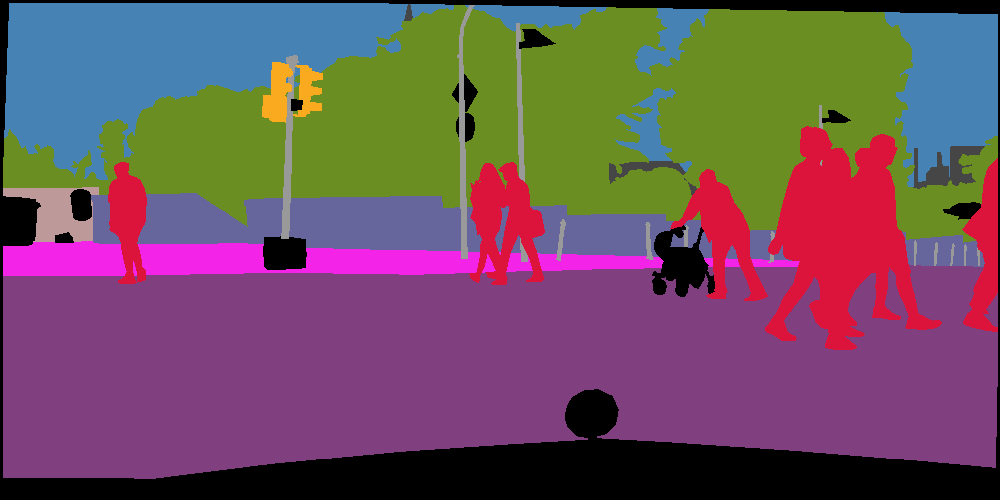

In [21]:
Image.fromarray(mask_to_rgb(y.numpy()))

In [22]:
train_dataset = torch.utils.data.DataLoader(
    cityscapesDataset(
        image_dir=os.path.join(main_path, "dataset", "leftImg8bit", "test"),
        mask_dir=os.path.join(main_path, "dataset", "gtFine", "test"),
        transform=A.Compose([
            A.Resize(height=500, width=1000),
            A.Rotate(limit=30, p=1.0),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.1),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # realizaremos transfer learning con parte un modelo entrenado sobre imagenet
            ToTensorV2(),
        ]),
        scale=False,
    ),
    batch_size=8,
    num_workers=1,
    shuffle=True,
    pin_memory=True,
)

# **Modelos**

### **Fully Convolutional Networks**

*Shelhamer, E., Long, J., & Darrell, T. (2016). Fully convolutional networks for semantic segmentation. arXiv:1605.06211. https://doi.org/10.48550/arXiv.1605.06211*

Arquitectura encoder-decoder caracterizada por sustuir las últimas capas de un modelo neuronal profundo diseñado para clasificación de imágenes por capas convolucionales. En concreto, sustituye las capas Fully Connected por capas Conv2D y posteriormente aplica métodos de upsampling mediante convoluciones traspuestas para recuperar la resolución espacial de la entrada (también llamadas backwards convolutions o fractional slide convolutions).

![image.png](attachment:image.png)

![image-2.png](attachment:image-2.png)

Se divide en múltiples subtipos, dependiendo de cómo se gestiona el proceso de upsampling. En su forma más básica, la salida de la red convolucional inicial o backbone es sometida directamente a un proceso de upsampling, como se muestra en la siguiente figura:

![image-3.png](attachment:image-3.png)

La red recibe el nombre de FCN-32.

Una mejora a esta arquitectura consiste en utilizar los mapas de características de salida de los bloques convolucionales anteriores del encoder y combinarlos mediante conexiones de salto, pues contienen información espacial sobre la localización de los objetos que hay que segmentar (el encoder aprende donde se localizan las entidades y el decoder a qué clases se corresonden). Para ello se aplican conexiones de salto o skip connections entre las salidas de las capas convolucionales del encoder y las salidas de las capas upsamling del decoder, con ciertas consideraciones que comentaremos después, dando lugar a una subfamilia de arquitecturas dentro de las FCNs:

![image-4.png](attachment:image-4.png)

Notar como la última arquitectura FCN8 utiliza la mayor cantidad de información del backbone de todas las demás.

Una vez introducida esta familia de arquitecturas veamos como definirla paso a paso. Siguiendo la práctica habitual en la implementación de redes FCN, lo primero es escoger la red *backbone*, es decir, aquella subred que constituye el encoder del modelo de segmentación. Normalmente se suele utilizar modelos profundos no demasiado complejos entrenados para clasificación de imágenes sobre el dataset *ImageNet*. En este sentido, las dos familias más utilizadas son VGG y ResNet, dado su alto rendimiento y su (relativa) eficiencia al eliminar las capas Fully Connected localizadas al final de la red (contienen la mayoría de parámetros del modelo).

En este tutorial y dado que la familia ResNet ya está implementada como backbone en la librería PyTorch (en concreto ResNet50 y ResNet101), trabajaremos sobre la familia VGG.

Por lo tanto, antes de la implementación de las FCNs daremos la implementación (prácticamente desde cero) de las redes vgg11, vgg13, vgg16 y vgg19 (más sus versiones con batch normalization) y descartaremos las capas Fully Connected de la red (el clasificador).

In [23]:
# configuraciones de cada red VGG
# cada lista contiene dos posibles elementos: el número de filtros de una capa convolucional o el carácter M, indicando que la capa correspondiente es una MaxPooling2D
vgg_configs = {
    'vgg11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'vgg19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

class VGGNet(torchvision.models.VGG): # Heredar de la clase VGG simplifica mucho la implementación
    def __init__(self, in_channels=3, load_weights=True, model='vgg16', batch_norm=True):
        """
        Inicialización del modelo VGG.

        Args:
            in_channels: numero de canales de las imagenes de entrada (3 para imagenes RGB)
            load_weights: determina si cargar los pesos pre-entrenados de la base de datos de Pytorch
            model: identificador del modelo. Debe corresonderse con una de las claves del diccionario 'vgg_configs'
            batch_norm: determina si aplicar batch normalization entre la salida de la capa convolucional y la funcion de activacion
        """

        self.in_channels = in_channels
        self.model = model
        self.batch_norm = batch_norm
        self.config = vgg_configs[self.model]

        if model not in vgg_configs.keys():
            raise ValueError(f"Value passed to the parameter model must be one of the keys of the dict 'vgg_configs'. Received {model}")

        # Mediante el método super heredamos la funcionalidad del constructor de la clase padre
        # lo que permite construir solo las capas necesarias para el problema actual
        super(VGGNet, self).__init__(self.set_features())

        # Carga de los pesos pre-entrenados sobre imagenet (transfer learning)
        if load_weights:
            model_name = model
            if batch_norm:
                model_name += "_bn"
            exec(f"self.load_state_dict(torchvision.models.{model_name}(pretrained=True).state_dict())")

        # Descartamos las capas AvgPooling y FullyConnected de la parte final de VGG
        del self.avgpool
        del self.classifier

    def set_features(self):
        """Crea las capas necesarias del modelo VGG"""

        in_channels = self.in_channels
        self.layers = []
        self.maxpool_locations = []

        for value in self.config:
            if value == "M":
                self.layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
                self.maxpool_locations.append(True)
            else:
                self.layers.append(nn.Conv2d(in_channels=in_channels, out_channels=value, kernel_size=3, padding=1))
                self.maxpool_locations.append(False)
                if self.batch_norm:
                    self.layers.append(nn.BatchNorm2d(num_features=value))
                    self.maxpool_locations.append(False)
                self.layers.append(nn.ReLU(inplace=True))
                self.maxpool_locations.append(False)
                in_channels = value

        return nn.Sequential(*self.layers)

    def forward(self, x):

        # output contiene una lista [x,height,width] por cada capa Maxpooling del modelo VGG,
        # donde x es la salida de cada capa Maxpooling y height y width son la altura y anchura
        # de la entrada de la capa maxpooling. De esta forma podemos ajustar los tamaños de las
        # salidas de las capas upsampling con el objetivo de que la salida del modelo de segmentacion
        # tenga el mismo tamaño que la entrada
        output = []

        for layer, max_pool in zip(self.features, self.maxpool_locations):
            if max_pool:
                heigth = x.shape[2]
                width = x.shape[3]
                x = layer(x)
                output.append([x, heigth, width])
            else:
                x = layer(x)

        return output

Comprobemos que el funcionamiento es el esperado:

In [24]:
myvgg = VGGNet()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:05<00:00, 96.6MB/s]


In [25]:
myvgg

VGGNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 

In [26]:
inp = torch.from_numpy(np.zeros((1, 3, 163, 249), dtype=np.float32))
out = myvgg(inp)

In [27]:
for i in out:
    print(i[0].shape, i[1], i[2])

torch.Size([1, 64, 81, 124]) 163 249
torch.Size([1, 128, 40, 62]) 81 124
torch.Size([1, 256, 20, 31]) 40 62
torch.Size([1, 512, 10, 15]) 20 31
torch.Size([1, 512, 5, 7]) 10 15


Una vez implementada la red backbone procedermos con la construcción de las redes FCNs, comenzando por la más sencilla: FCN32

![image.png](attachment:image.png)

La idea original consiste en sustituir las capas FullyConnected del backbone por capas convolucionales (conv6-7) y realizar el upsampling en un solo paso mediante una convolución traspuesta (backwards convolution), preferiblemente mediante un kernel no congelado (learnable upsampling). Finalmente se aplica una convolución con kernel 1x1 (pointwise convolution) para que el número de canales de salida coincida con el número de clases del problema de segmentación, resultando en los logits sobre los que aplicar las funciones softmax y argmax para obtener la clase predicha para cada pixel.

In [28]:
def bilinear_kernel(in_channels, out_channels, kernel_size):
    """Crea un kernel fijo para realizar interpolacion bilineal mediante una capa Conv2dTranspose
    http://d2l.ai/chapter_computer-vision/fcn.html"""
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = (torch.arange(kernel_size).reshape(-1, 1), torch.arange(kernel_size).reshape(1, -1))
    filt = (1 - torch.abs(og[0] - center) / factor) * (1 - torch.abs(og[1] - center) / factor)
    weight = torch.zeros((in_channels, out_channels, kernel_size, kernel_size))
    weight[range(in_channels), range(out_channels), :, :] = filt
    return weight

In [29]:
conv_trans = nn.ConvTranspose2d(in_channels=3, out_channels=3, kernel_size=4, padding=1, stride=2, bias=False)
conv_trans.weight.data.copy_(bilinear_kernel(3, 3, 4))
conv_trans.requires_grad = False # evita la actualizacion durante el backward pass

In [30]:
x = torch.from_numpy(np.zeros((1,3,5,7), dtype=np.float32))
nn.ConvTranspose2d(in_channels=3, out_channels=3, kernel_size=2, stride=2, padding=0, output_padding=0)(x).shape

torch.Size([1, 3, 10, 14])

In [31]:
class FCN32s(nn.Module):
    def __init__(self, vgg_backbone, num_classes=20, batch_norm=False, apply_relu=False, upsampling="bilinear"):
        super(FCN32s, self).__init__()

        if upsampling not in {"bilinear", "learnable"}:
            raise ValueError(f"Value passed to the parameter 'upsampling' must be 'bilinear' or 'learnable'. Received {upsampling}")

        self.num_classes = num_classes
        self.vgg_backbone = vgg_backbone
        self.upsampling = upsampling
        self.apply_relu = apply_relu
        self.batch_norm = batch_norm

        if self.apply_relu:
            self.relu = nn.ReLU(inplace=True)


        self.conv1 = nn.Conv2d(in_channels=512, out_channels=4096, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=4096, out_channels=4096, kernel_size=3, padding=1)

        if self.batch_norm:
            self.bn1 = nn.BatchNorm2d(num_features=4096)
            self.bn2 = nn.BatchNorm2d(num_features=4096)

        self.pointwise_conv = nn.Conv2d(4096, self.num_classes, kernel_size=1)

        self.up32 = nn.ConvTranspose2d(in_channels=num_classes, out_channels=num_classes, kernel_size=32, stride=32, padding=0, output_padding=0)

    def forward(self, x):

        backbone_out = self.vgg_backbone(x)

        x5 = backbone_out[-1][0]         # shape (N, 512, H//32, W//32)
        x = self.conv1(x5)               # shape (N, 512, H//32, W//32)
        if self.batch_norm:
            x = self.bn1(x)              # shape (N, 512, H//32, W//32)
        if self.apply_relu:
            x = self.relu(x)             # shape (N, 512, H//32, W//32)
        x = self.conv2(x)                # shape (N, 512, H//32, W//32)
        if self.batch_norm:
            x = self.bn2(x)              # shape (N, 512, H//32, W//32)
        if self.apply_relu:
            x = self.relu(x)             # shape (N, 512, H//32, W//32)
        x = self.pointwise_conv(x)       # shape (N, num_classes, H//32, W//32)

        x = self.up32(x)                 # shape (N, num_classes, H', W')

        return x

In [32]:
vggnet = VGGNet()

In [33]:
model = FCN32s(vgg_backbone=vggnet)

In [34]:
x = torch.from_numpy(np.zeros((1,3,160,256), dtype=np.float32))
model(x).shape

torch.Size([1, 20, 160, 256])

En la celda anterior las dimensiones del tensor *x* han sido escogidas de modo que la altura y anchura sean ambas divisibles por 32. ¿Que ocurriría en caso contrario?

In [35]:
x = torch.from_numpy(np.zeros((1,3,160,240), dtype=np.float32))
model(x).shape

torch.Size([1, 20, 160, 224])

Notar como perdemos la resolución espacial de la entrada. El motivo es el mismo que el observado en la práctica anterior, donde se entrenó una red UNET para resolver un problema de segmentación semántica binaria, y se debe al uso de cuatro operaciones de MaxPooling2D con kernel cuadrado y stride=2 en la red backbone, cada una reduciendo el tamaño de la entrada en un factor de dos unidades.

Para resolver este incoveniente ajustaremos las dimensiones de forma similar a como se hizo en la implementación de la red UNET. Sin embargo, al contrario que por aquel entonces, no disponemos de las entradas de la capa MaxPool2D para calcular la diferencia entre la altura y anchura (en la red UNET se podían calcular a través de las skip connections).

Para ello se modificó el forward pass de la implementación de la red VGG de modo que devolviera una lista formada por sublistas de tres elementos (para capa maxpooling2d del backbone):
* La salida de la capa maxpool
* La altura de la entrada a la capa maxpool
* La anchura de la entrada a la capa maxpool

De esta forma sabemos cuales eran las dimensiones antes de aplicar maxpooling2d en el backbone, lo que permite aplicar métodos de upsampling estáticos (un-learnables) sobre la salida de la capa Conv2Dtranpose en la seccion de la red FCN posterior al backbone con el objetivo de que la salida final mantenga la resolución espacial de la entrada original.

**Ejercicio**: razonar porqué es necesario realizar el ajuste del tamaño después de aplicar la capa conv2dtranpose

In [36]:
class FCN32s(nn.Module):
    def __init__(self, vgg_backbone, num_classes=20, apply_relu=False, batch_norm=False, adjust_shapes="interpolate"):
        super(FCN32s, self).__init__()

        if adjust_shapes not in {"interpolate", "zeropad"}:
            raise ValueError(f"Value passed to the parameter 'upsampling' must be 'interpolate' or 'zeropad'. Received {adjust_shapes}")

        if adjust_shapes == "interpolate":
            self.adjust_shapes = lambda x, height, width: F.interpolate(x, size=(height, width), mode='bilinear')
        elif adjust_shapes == "zeropad":
            def adjust_shapes(x, height, width):
                height_diff = height - x.size(2)
                width_diff = width - x.size(3)
                pad_left = width_diff // 2
                pad_right = width_diff - pad_left
                pad_top = height_diff // 2
                pad_bottom = height_diff - pad_top
                return F.pad(x, pad=(pad_left, pad_right, pad_top, pad_bottom), mode='constant', value=0)
            self.adjust_shapes = adjust_shapes

        self.num_classes = num_classes
        self.vgg_backbone = vgg_backbone

        self.apply_relu = apply_relu
        self.batch_norm = batch_norm

        if self.apply_relu:
            self.relu = nn.ReLU(inplace=True)

        self.conv1 = nn.Conv2d(in_channels=512, out_channels=4096, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=4096, out_channels=4096, kernel_size=3, padding=1)

        if self.batch_norm:
            self.bn1 = nn.BatchNorm2d(num_features=4096)
            self.bn2 = nn.BatchNorm2d(num_features=4096)

        self.pointwise_conv = nn.Conv2d(in_channels=4096, out_channels=self.num_classes, kernel_size=1)

        self.up32 = nn.ConvTranspose2d(in_channels=num_classes, out_channels=num_classes, kernel_size=32, stride=32, padding=0, output_padding=0)

    def forward(self, x):

        backbone_out = self.vgg_backbone(x)

        x5, _, _ = backbone_out[-1]                  # shape (N, 512, H//32, W//32)
        _, height, width = backbone_out[0]           # original height and width

        x = self.conv1(x5)                           # shape (N, 512, H//32, W//32)
        if self.batch_norm:
            x = self.bn1(x)                          # shape (N, 512, H//32, W//32)
        if self.apply_relu:
            x = self.relu(x)                         # shape (N, 512, H//32, W//32)
        x = self.conv2(x)                            # shape (N, 512, H//32, W//32)
        if self.batch_norm:
            x = self.bn2(x)                          # shape (N, 512, H//32, W//32)
        if self.apply_relu:
            x = self.relu(x)                         # shape (N, 512, H//32, W//32)
        x = self.pointwise_conv(x)                   # shape (N, num_classes, H//32, W//32)

        x = self.up32(x)                             # shape (N, num_classes, H', W')

        if not x.shape[2] == height or not x.shape[3] == width:
            x = self.adjust_shapes(x, height, width) # shape (N, num_classes, H, W)

        return x

In [37]:
model = FCN32s(vgg_backbone=vggnet, adjust_shapes="interpolate")
x = torch.from_numpy(np.zeros((1,3,160,240), dtype=np.float32))
model(x).shape

torch.Size([1, 20, 160, 240])

In [38]:
model = FCN32s(vgg_backbone=vggnet, adjust_shapes="zeropad")
x = torch.from_numpy(np.zeros((1,3,160,240), dtype=np.float32))
model(x).shape

torch.Size([1, 20, 160, 240])

Siguiendo con el resto de arquitecturas de la familia FCNs:

![image-2.png](attachment:image-2.png)

En el paper original, los autores comentan como realizar upsampling con strides=32 limita los detalles del mapa de segmentación final. Dicho de otra forma, FCN32 realiza upsampling a lo bruto, de una tancada, por lo que por mucho que tratemos de mejorar los resultados del modelo (entrenamientos más sofisticados) el rendimiento final no será adecuado, ya que los mapas de segmentación resultantes pierden la localización de los objetos en la imágen original que queremos segmentar (el backbone aprende el where y el decoder aprende el what), por lo que combinando los feature maps de capas anteriores a la capa final del backbone observaron como el modelo era capaz de aprender finos detalles de la segmentación (combinación mediante skip connections y varias operaciones de upsampling gradual).

Duplicando la operación de upsampling en dos partes: x2 sobre la salida del backbone (llamemosle z) y x16 sobre la suma de z con la salida de la penúltima capa maxpool del backbone se obtiene la arquitectura FCN-16S.

Similarmente, aplicando la misma operación entre la antepenúltima capa maxpool del  backbone y la suma anterior, se obtiene la arquitectura FCN-8s (la s viene de stride=8 en la última conv2dtranspose)

In [39]:
class FCN16s(nn.Module):
    def __init__(self, vgg_backbone, num_classes=20, apply_relu=False, batch_norm=False, adjust_shapes="interpolate"):
        super(FCN16s, self).__init__()

        if adjust_shapes not in {"interpolate", "zeropad"}:
            raise ValueError(f"Value passed to the parameter 'upsampling' must be 'interpolate' or 'zeropad'. Received {adjust_shapes}")

        if adjust_shapes == "interpolate":
            self.adjust_shapes = lambda x, height, width: F.interpolate(x, size=(height, width), mode='bilinear')
        elif adjust_shapes == "zeropad":
            def adjust_shapes(x, height, width):
                height_diff = height - x.size(2)
                width_diff = width - x.size(3)
                pad_left = width_diff // 2
                pad_right = width_diff - pad_left
                pad_top = height_diff // 2
                pad_bottom = height_diff - pad_top
                return F.pad(x, pad=(pad_left, pad_right, pad_top, pad_bottom), mode='constant', value=0)
            self.adjust_shapes = adjust_shapes

        self.num_classes = num_classes
        self.vgg_backbone = vgg_backbone
        self.apply_relu = apply_relu
        self.batch_norm = batch_norm

        if self.apply_relu:
            self.relu = nn.ReLU(inplace=True)

        self.conv1 = nn.Conv2d(in_channels=512, out_channels=4096, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=4096, out_channels=4096, kernel_size=3, padding=1)

        if self.batch_norm:
            self.bn1 = nn.BatchNorm2d(num_features=4096)
            self.bn2 = nn.BatchNorm2d(num_features=4096)


        self.pointwise_conv1 = nn.Conv2d(in_channels=4096, out_channels=self.num_classes, kernel_size=1)
        self.pointwise_conv2 = nn.Conv2d(in_channels=512, out_channels=self.num_classes, kernel_size=1)

        self.upx2 = nn.ConvTranspose2d(in_channels=num_classes, out_channels=num_classes, kernel_size=2, stride=2, padding=0, output_padding=0)
        self.upx16 = nn.ConvTranspose2d(in_channels=num_classes, out_channels=num_classes, kernel_size=16, stride=16, padding=0, output_padding=0)



    def forward(self, x):

        backbone_out = self.vgg_backbone(x)

        x5, height5, width5 = backbone_out[-1]          # shape (N, 512, H//32, W//32)
        x4, _, _ = backbone_out[-2]                     # shape (N, 256, H//16, W//16)

        _, height, width = backbone_out[0]              # original height and width

        x = self.conv1(x5)                              # shape (N, 512, H//32, W//32)
        if self.batch_norm:
            x = self.bn1(x)                             # shape (N, 512, H//32, W//32)
        if self.apply_relu:
            x = self.relu(x)                            # shape (N, 512, H//32, W//32)
        x = self.conv2(x)                               # shape (N, 512, H//32, W//32)
        if self.batch_norm:
            x = self.bn2(x)                             # shape (N, 512, H//32, W//32)
        if self.apply_relu:
            x = self.relu(x)                            # shape (N, 512, H//32, W//32)
        x = self.pointwise_conv1(x)                     # shape (N, num_classes, H//32, W//32)

        x = self.upx2(x)                                # shape (N, num_classes, H//16, W//16)

        if not x.shape[2] == height5 or not x.shape[3] == width5:
            x = self.adjust_shapes(x, height5, width5)

        x = x + self.pointwise_conv2(x4)                # shape (N, num_classes, H//16, W//16)

        x = self.upx16(x)                               # shape (N, num_classes, H', W')

        if not x.shape[2] == height or not x.shape[3] == width:
            x = self.adjust_shapes(x, height, width)    # shape (N, num_classes, H, W)

        return x

In [40]:
model = FCN16s(vgg_backbone=vggnet)
x = torch.from_numpy(np.zeros((1,3,160,240), dtype=np.float32))
model(x).shape

torch.Size([1, 20, 160, 240])

In [41]:
class FCN8s(nn.Module):
    def __init__(self, vgg_backbone, num_classes=20, apply_relu=False, batch_norm=False, adjust_shapes="interpolate"):
        super(FCN8s, self).__init__()

        if adjust_shapes not in {"interpolate", "zeropad"}:
            raise ValueError(f"Value passed to the parameter 'upsampling' must be 'interpolate' or 'zeropad'. Received {adjust_shapes}")

        if adjust_shapes == "interpolate":
            self.adjust_shapes = lambda x, height, width: F.interpolate(x, size=(height, width), mode='bilinear')
        elif adjust_shapes == "zeropad":
            def adjust_shapes(x, height, width):
                height_diff = height - x.size(2)
                width_diff = width - x.size(3)
                pad_left = width_diff // 2
                pad_right = width_diff - pad_left
                pad_top = height_diff // 2
                pad_bottom = height_diff - pad_top
                return F.pad(x, pad=(pad_left, pad_right, pad_top, pad_bottom), mode='constant', value=0)
            self.adjust_shapes = adjust_shapes

        self.num_classes = num_classes
        self.vgg_backbone = vgg_backbone
        self.apply_relu = apply_relu
        self.batch_norm = batch_norm

        if self.apply_relu:
            self.relu = nn.ReLU(inplace=True)

        self.conv1 = nn.Conv2d(in_channels=512, out_channels=4096, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=4096, out_channels=4096, kernel_size=3, padding=1)

        if self.batch_norm:
            self.bn1 = nn.BatchNorm2d(num_features=4096)
            self.bn2 = nn.BatchNorm2d(num_features=4096)

        self.pointwise_conv0 = nn.Conv2d(in_channels=4096, out_channels=self.num_classes, kernel_size=1)
        self.pointwise_conv1 = nn.Conv2d(in_channels=512, out_channels=self.num_classes, kernel_size=1)
        self.pointwise_conv2 = nn.Conv2d(in_channels=256, out_channels=self.num_classes, kernel_size=1)

        self.upx2_1 = nn.ConvTranspose2d(in_channels=num_classes, out_channels=num_classes, kernel_size=2, stride=2, padding=0, output_padding=0)
        self.upx2_2 = nn.ConvTranspose2d(in_channels=num_classes, out_channels=num_classes, kernel_size=2, stride=2, padding=0, output_padding=0)
        self.upx8 = nn.ConvTranspose2d(in_channels=num_classes, out_channels=num_classes, kernel_size=8, stride=8, padding=0, output_padding=0)



    def forward(self, x):

        backbone_out = self.vgg_backbone(x)

        x5, height5, width5 = backbone_out[-1]          # shape (N, 512, H//32, W//32)   height5=H//32  width5=W//32
        x4, height4, width4 = backbone_out[-2]          # shape (N, 512, H//16, W//16)   height5=H//16  width5=W//16
        x3, _, _ = backbone_out[-3]                     # shape (N, 256, H//8, W//8)     height5=H//8  width5=W//8

        _, height, width = backbone_out[0]              # shape (N, 64, H//2, W//2)      heigth1=H      width1=W (original)

        x = self.conv1(x5)                              # shape (N, 512, H//32, W//32)
        if self.batch_norm:
            x = self.bn1(x)
        if self.apply_relu:
            x = self.relu(x)
        x = self.conv2(x)
        if self.batch_norm:
            x = self.bn2(x)
        if self.apply_relu:
            x = self.relu(x)                             # shape (N, 512, H//32, W//32)
        x = self.pointwise_conv0(x)                      # shape (N, num_classes, H//32, W//32)

        x = self.upx2_1(x)

        if not x.shape[2] == height5 or not x.shape[3] == width5:
            x = self.adjust_shapes(x, height5, width5)

        x = x + self.pointwise_conv1(x4)

        x = self.upx2_2(x)

        if not x.shape[2] == height4 or not x.shape[3] == width4:
            x = self.adjust_shapes(x, height4, width4)

        x = x + self.pointwise_conv2(x3)

        x = self.upx8(x)

        if not x.shape[2] == height or not x.shape[3] == width:
            x = self.adjust_shapes(x, height, width)

        return x

In [42]:
model = FCN8s(vgg_backbone=vggnet)
x = torch.from_numpy(np.zeros((1,3,160,240), dtype=np.float32))
model(x).shape

torch.Size([1, 20, 160, 240])

**Ejercicio**: escoge cualquiera de las FCNs y modifica su arquitectura adecuadamente

Pista:

- Añadir más capas y/o mayor no linealidad
- Modificar las skips connnections
- FCN-Xs


**no es necesario cambiar el backbone**


In [43]:
class myFCN(nn.Module):
    def __init__(self, vgg_backbone, num_classes, adjust_shapes="interpolate"):
        super().__init__()

        if adjust_shapes not in {"interpolate", "zeropad"}:
            raise ValueError(f"Value passed to the parameter 'upsampling' must be 'interpolate' or 'zeropad'. Received {adjust_shapes}")

        if adjust_shapes == "interpolate":
            self.adjust_shapes = lambda x, height, width: F.interpolate(x, size=(height, width), mode='bilinear')
        elif adjust_shapes == "zeropad":
            def adjust_shapes(x, height, width):
                height_diff = height - x.size(2)
                width_diff = width - x.size(3)
                pad_left = width_diff // 2
                pad_right = width_diff - pad_left
                pad_top = height_diff // 2
                pad_bottom = height_diff - pad_top
                return F.pad(x, pad=(pad_left, pad_right, pad_top, pad_bottom), mode='constant', value=0)
            self.adjust_shapes = adjust_shapes

        self.num_classes = num_classes
        self.vgg_backbone = vgg_backbone

        #####################
        ## escribir codigo ##
        #####################

    def forward(self, x):

        backbone_out = self.vgg_backbone(x)

        x5, height5, width5 = backbone_out[-1]          # shape (N, 512, H//32, W//32)   height5=H//32  width5=W//16
        x4, height4, width4 = backbone_out[-2]          # shape (N, 256, H//16, W//16)   height4=H//16  width4=W//16
        x3, height3, width3 = backbone_out[-3]          # shape (N, 256, H//8, W//8)     height3=H//4   width3=W//4
        x2, height2, width2 = backbone_out[-4]          # shape (N, 128, H//4, W//4)     height2=H//2   width2=W//2
        x1, height1, width1 = backbone_out[-5]          # shape (N, 64, H//2, W//2)      heigth1=H      width1=W (original)

        #####################
        ## escribir codigo ##
        #####################

        return x

In [44]:
class aFCN2s(nn.Module):
    def __init__(self, vgg_backbone, num_classes=20, adjust_shapes="interpolate"):
        super().__init__()

        if adjust_shapes not in {"interpolate", "zeropad"}:
            raise ValueError(f"Value passed to the parameter 'upsampling' must be 'interpolate' or 'zeropad'. Received {adjust_shapes}")

        if adjust_shapes == "interpolate":
            self.adjust_shapes = lambda x, height, width: F.interpolate(x, size=(height, width), mode='bilinear')
        elif adjust_shapes == "zeropad":
            def adjust_shapes(x, height, width):
                height_diff = height - x.size(2)
                width_diff = width - x.size(3)
                pad_left = width_diff // 2
                pad_right = width_diff - pad_left
                pad_top = height_diff // 2
                pad_bottom = height_diff - pad_top
                return F.pad(x, pad=(pad_left, pad_right, pad_top, pad_bottom), mode='constant', value=0)
            self.adjust_shapes = adjust_shapes

        self.num_classes = num_classes
        self.vgg_backbone = vgg_backbone

        self.relu = nn.ReLU(inplace=True)
        self.up5 = nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=2, stride=2, padding=0, output_padding=0)
        self.bn5 = nn.BatchNorm2d(num_features=512)
        self.up4 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2, stride=2, padding=0, output_padding=0)
        self.bn4 = nn.BatchNorm2d(num_features=256)
        self.up3 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2, padding=0, output_padding=0)
        self.bn3 = nn.BatchNorm2d(num_features=128)
        self.up2 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2, padding=0, output_padding=0)
        self.bn2 = nn.BatchNorm2d(num_features=64)
        self.up1 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=2, stride=2, padding=0, output_padding=0)
        self.bn1 = nn.BatchNorm2d(num_features=64)

        self.pointwise_conv = nn.Conv2d(in_channels=64, out_channels=self.num_classes, kernel_size=1)

        self.pointwise_conv5 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=1)
        self.pointwise_conv4 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=1)
        self.pointwise_conv3 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=1)
        self.pointwise_conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1)
        self.pointwise_conv1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1)

    def forward(self, x):

        backbone_out = self.vgg_backbone(x)

        x5, height, width = backbone_out[-1] # shape (N, 512, H//32, W//32)   height5=H//32  width5=W//32
        x = self.up5(x5)
        if not x.shape[2] == height or not x.shape[3] == width:
            x = F.interpolate(x, size=(height, width), mode='bilinear')
        x = self.bn5(x)
        x = self.relu(x)

        x4, height, width = backbone_out[-2] # shape (N, 256, H//16, W//16)   height4=H//16  width4=W//16
        x = x + self.pointwise_conv5(x4)

        x = self.up4(x)
        if not x.shape[2] == height or not x.shape[3] == width:
            x = F.interpolate(x, size=(height, width), mode='bilinear')
        x = self.bn4(x)
        x = self.relu(x)

        x3, height, width = backbone_out[-3] # shape (N, 256, H//8, W//8)     height3=H//4   width3=W//4
        x = x + self.pointwise_conv4(x3)

        x = self.up3(x)
        if not x.shape[2] == height or not x.shape[3] == width:
            x = F.interpolate(x, size=(height, width), mode='bilinear')
        x = self.bn3(x)
        x = self.relu(x)

        x2, height, width = backbone_out[-4] # shape (N, 128, H//4, W//4)     height2=H//2   width2=W//2
        x = x + self.pointwise_conv3(x2)

        x = self.up2(x)
        if not x.shape[2] == height or not x.shape[3] == width:
            x = F.interpolate(x, size=(height, width), mode='bilinear')
        x = self.bn2(x)
        x = self.relu(x)

        x1, height, width = backbone_out[-5] # shape (N, 64, H//2, W//2)      heigth1=H      width1=W (original)
        x = x + self.pointwise_conv2(x1)

        x = self.up1(x)
        if not x.shape[2] == height or not x.shape[3] == width:
            x = F.interpolate(x, size=(height, width), mode='bilinear')
        x = self.bn1(x)
        x = self.relu(x)                    # shape (N, 32, H, W)

        x = self.pointwise_conv(x)          # shape (N, num_classes, H, W)

        return x

In [45]:
model = aFCN2s(vgg_backbone=vggnet, num_classes=21)
x = torch.from_numpy(np.zeros((1,3,160,240), dtype=np.float32))
model(x).shape

torch.Size([1, 21, 160, 240])

# **Entrenamiento**

In [46]:
# Establece como device el dispositvo más adecuado para ejecutar el entrenamiento en base a la capacidad de nuestro sistema
device = (
    "cuda" # Nvidia CUDA-compatible GPU
    if torch.cuda.is_available()
    else "mps" # MPS-compatible MAC computer
    if torch.backends.mps.is_available()
    else "cpu" # General purpose PC with 64bit CPU
)

In [57]:
import torch

# callback early stopping para terminar el entrenamiento cuando la metrica en el conjunto de validacion se estanca, empeora o no mejora lo suficiente conforme aumentan las epocas
class earlyStopping:
    def __init__(self, patience=3, min_delta=0.0, mode="min"):
        """
        Args:
            patience (int): El entrenamiento para si en 'patience' numero de epocas la metrica de monitorizacion no ha mejorado
            min_delta (float): Cambio minimo en valor absoluto en la metrica de monitorizacion para considerar el resultado como una mejora respecto de la epoca anterior
            mode (str): Uno de los valores 'max' o 'min'. Determina si el objetivo es minimizar o maximizar la metrica de monitorizacion
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0 # inicializar el contador de epocas en la que la metrica no mejora
        self.stop = False # boolean flag para que determina cuando ha de parar el entrenamiento
        self.mode = mode

        if self.mode not in {"min", "max"}:
            raise ValueError(f"The value passed to the parameter 'mode' must be either 'max' or 'min'. Received {self.mode}")

        if self.min_delta < 0.0:
            raise ValueError(f"The value passed to the parameter min_delta must be greater than or equal to zero. Received {self.min_delta}")

        if self.mode == "max":
            self.best_score = 0.0
        else:
            self.best_score = 1e10

    def __call__(self, new_score):

        if self.mode == "max":
            metric_improved = (new_score - self.best_score > self.min_delta)
        elif self.mode == "min":
            metric_improved = (self.best_score - new_score > self.min_delta)

        if metric_improved:
            self.best_score = new_score
            self.counter = 0
        else:
            # si la metrica no ha mejorado añadimos una unidad al contador de epocas sin mejora
            self.counter += 1
            # comprobamos si hay que parar el entrenamiento
            if self.counter == self.patience:
                self.stop = True


# callback model checkpoint para guardar el mejor modelo obtenido hasta la fecha (pesos del modelo y estado del optimizador)
class modelCheckpoint:
    def __init__(self, path, min_delta=0.0, mode="min"):
        """
        Args:
            path (str): ruta donde almacenar los pesos del modelo y el estado del optimizador
        """
        if not path:
            path = "unerCarvana.pth"
        self.path = path
        self.mode = mode
        self.min_delta = min_delta

        if self.mode not in {"min", "max"}:
            raise ValueError(f"The value passed to the parameter 'mode' must be either 'max' or 'min'. Received {self.mode}")

        if self.min_delta < 0.0:
            raise ValueError(f"The value passed to the parameter min_delta must be greater than or equal to zero. Received {self.min_delta}")

        if self.mode == "max":
            self.best_score = 0.0
        else:
            self.best_score = 1e10

    def __call__(self, model, optimizer, new_score):

        if self.mode == "max":
            metric_improved = (new_score - self.best_score > self.min_delta)
        elif self.mode == "min":
            metric_improved = (self.best_score - new_score > self.min_delta)

        if metric_improved:
            torch.save({
                'model_state_dict' : model.state_dict(),
                'optimizer_state_dict' : optimizer.state_dict(),
                }, self.path)
            self.best_score = new_score



def savePredicionsAsComposedImage(
        dataset,
        image_dir,
        mask_dir,
        image_height,
        image_width,
        batch_size,
        num_workers,
        pin_memory,
        model,
        device,
        aux=False,
        dir=os.path.join("dataset", "predictions"),
        n_samples=10
    ):
    # Crea el directorio 'dir' si no existe
    if not os.path.exists(dir):
        os.makedirs(dir)

    model = model.to(device)

    original_dataset = torch.utils.data.DataLoader(
    cityscapesDataset(
        image_dir=image_dir,
        mask_dir=mask_dir,
        transform=A.Compose([
            A.Resize(height=image_height, width=image_width),
            ToTensorV2()
        ]),
        scale=True,
    ),
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=False,
    pin_memory=pin_memory,
    )

    # Pasa el modelo a modo evaluacion
    model.eval()
    # Evitar el calculo de gradientes
    with torch.no_grad():
        # Iterar sobre el dataset
        counter = 0
        for (original, _), (x, y) in zip(original_dataset, dataset):
            # Mover los tensores al device
            x, y = x.to(device), y.to(device)
            preds = model(x)
            if aux:
                preds = preds["out"]
            preds = torch.softmax(preds, dim=1)
            preds = torch.argmax(preds, dim=1)
            for i in range(x.size(0)):
                concatenated = torch.cat(
                    [
                        original[i],
                        torch.from_numpy(np.transpose(mask_to_cityscapes_rgb(y[i].cpu().numpy()), (2,0,1))),
                        torch.from_numpy(np.transpose(mask_to_cityscapes_rgb(preds[i].cpu().numpy()), (2,0,1)))
                    ],
                    dim=2)
                image = torch_to_pil(concatenated)
                image.save(os.path.join(dir, f"{counter}.jpg"))
                counter += 1
                if counter == n_samples:
                    # Pasa el modelo a modo entrenamiento
                    model.train()
                    return None
    model.train()


Mediante la siguiente función evaluamos el rendimiento del modelo. Notar la aplicación de las funciones softmax y argmax para la conversión de los logits a los índices de la clase predicha.

In [58]:
# Evalua el rendimiento de un modelo para un problema de segmentación semantica binaria
# Asume que el dataset devuelve como ground truth una mascara 2D y que el modelo devuelve como predicciones los logits
def evaluate(dataset, model, loss_fn, device):
    # Inicializar metricas a cero
    loss = acc = 0
    # Poner el modelo en modo evaluacion
    model.eval()
    # Evita el calculo de los gradientes
    with torch.no_grad():
        # Itera sobre el dataset
        for x, y in dataset:
            # Mover los tensores al device elegido
            x, y = x.to(device), y.to(device).to(torch.long)
            # Calcular predicciones y descartar la dimension vacía
            preds = model(x)
            # Carcular función de coste y actualizar variable
            loss += loss_fn(preds, y)
            preds = torch.softmax(preds, dim=1)
            preds = torch.argmax(preds, dim=1)
            # Calcular accuracy y actualizar variable
            acc += (preds == y).sum() / torch.numel(preds)
    # Cambiar el modelo a modo entrenamiento
    model.train()
    # Normalizar metricas por la longitud del dataloader
    loss = loss / len(dataset)
    acc = acc / len(dataset)
    return loss, acc

**Ejercicio**: Modificar la función evaluate de modo que, además de los valores de la función de coste y accuracy, develva el valor de la métrica mIoU (mean Intersection over Union). Puedes utilizar la librería torchmetrics o las funciones definidas en la primera práctica (bonus: incorporar un parámetro que permita seleccionar entre las estrategias de promediado micro, macro y weigthed)

In [59]:
def IoU(preds, target, class_index=1, eps=1e-6):
    """
    Calculo del IoU (Jaccard Index) para una clase.
    Args:
    - preds: mascara predicha (torch.tensor)
    - target: mascara verdadera (torch.tensor).
    - class_index: indice de la clase (1 para clasificación binaria)
    Returns:
    - IoU score para una clase
    """

    # Conversion a clasificacion binaria
    pred_bool = (preds == class_index)
    target_bool = (target == class_index)

    # Número de pixeles en la intersección entre mascara predicha y verdadera
    intersection = (pred_bool & target_bool).sum().item()
    # Numero de pixeles en la unión entre mascara predicha y verdadera
    union = (pred_bool | target_bool).sum().item()

    return intersection / (union + eps)

def mIoU(preds, target, num_classes):
    """
    Calculo del IoU promedio para un problema de segmentación semántica multiclase
    Args:
    - preds: mascara predicha (tensor)
    - target: mascara verdadera (tensor).
    - num_classes: numero total de clases
    Returns:
      IoU promediado sobre las clases
    """

    miou = 0

    # Calcula IoU para cada clase y acumula los valores en la variable miou
    for class_index in range(num_classes):
      miou += IoU(preds, target, class_index)

    # Normalizar por el número de clases
    miou = miou / num_classes

    return miou

In [60]:
!pip install torchmetrics
import torchmetrics
jaccard = torchmetrics.JaccardIndex(task="multiclass", num_classes=20, average="macro").to(device)

In [61]:
model = torchvision.models.segmentation.fcn_resnet50(num_classes=21).to(device)
#model.load_state_dict(torch.load(os.path.join("models", "fcns", "fcnresnet50-500x1000-e25-bs4.pth"))["model_state_dict"])

In [62]:
# Evalua el rendimiento de un modelo para un problema de segmentación semantica binaria
# Asume que el dataset devuelve como ground truth una mascara 2D y que el modelo devuelve como predicciones los logits
def evaluate(dataset, model, loss_fn, device, aux=False):
    # Inicializar metricas a cero
    loss = acc = miou = 0
    # Poner el modelo en modo evaluacion
    model.eval()
    # Evita el calculo de los gradientes
    with torch.no_grad():
        # Itera sobre el dataset
        for x, y in dataset:
            # Mover los tensores al device elegido
            x, y = x.to(device), y.to(device).to(torch.long)
            # Calcular predicciones y descartar la dimension vacía
            preds = model(x)
            if aux:
                preds = preds["out"]
            # Carcular función de coste y actualizar variable
            loss += loss_fn(preds, y).item()
            miou += jaccard(preds, y).item()
            preds = torch.softmax(preds, dim=1)
            preds = torch.argmax(preds, dim=1)
            # Calcular accuracy y actualizar variable
            acc += (preds == y).sum() / torch.numel(preds)
    # Cambiar el modelo a modo entrenamiento
    model.train()
    # Normalizar metricas por la longitud del dataloader
    loss = loss / len(dataset)
    acc = acc.item() / len(dataset)
    miou = miou / len(dataset)
    return loss, acc, miou

La siguiente función engloba todo el proceso de entrenamiento:

In [63]:
def train(
        model,
        loss_fn,
        device,
        image_height,
        image_width,
        learning_rate=0.0001,
        image_train_directory=os.path.join("dataset", "leftImg8bit", "train"),
        mask_train_directory=os.path.join("dataset", "gtFine", "train"),
        image_test_directory=os.path.join("dataset", "leftImg8bit", "val"),
        mask_test_directory=os.path.join("dataset", "gtFine", "val"),
        batch_size=4,
        num_workers=1,
        shuffle=True,
        pin_memory=True,
        pretrained_model=None,
        model_checkpoint=True,
        early_stopping=True,
        patience=4,
        min_delta=0.0,
        n_epochs = 5,
        model_path="model.pth",
        predictions_path=os.path.join("precitions", "model"),
        aug_transform_train=None,
        aug_transform_test=None,
        scale=False,
        monitoring_metric="miou",
        aux=False
        ):

    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Ruta donde almacenaremos el modelo en formato pth
    if model_path:
        # Si el directorio que contiene la ruta del modelo no existe lo creamos
        dirname = os.path.dirname(model_path)
        if dirname and not os.path.exists(dirname):
            os.makedirs(dirname)
        logs_path = model_path.replace(".pth", "-logs.txt")
        logs = {}

    # Construir el dataloader de entrenamiento
    train_dataset = torch.utils.data.DataLoader(
        cityscapesDataset(
            image_dir=image_train_directory,
            mask_dir=mask_train_directory,
            transform=aug_transform_train,
            scale=scale,
        ),
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=shuffle,
        pin_memory=pin_memory,
    )


    # Construir el dataloader de entrenamiento
    test_dataset = torch.utils.data.DataLoader(
        cityscapesDataset(
            image_dir=image_test_directory,
            mask_dir=mask_test_directory,
            transform=aug_transform_test,
            scale=scale,
        ),
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=False,
        pin_memory=pin_memory,
    )

    # comprueba si se ha especificado modelo pre-entrenado
    if pretrained_model:
        # carga del fichero pth
        ckpt = torch.load(pretrained_model)
        # carga los pesos al modelo
        model.load_state_dict(ckpt["model_state_dict"])
        # carga el estado del optimizador (importante!!)
        optimizer.load_state_dict(ckpt["optimizer_state_dict"])
        # evalua el rendimiento del modelo pre-entrenado
        train_loss, train_acc, train_miou = evaluate(train_dataset, model, loss_fn, device, aux=aux)
        test_loss, test_acc, test_miou = evaluate(test_dataset, model, loss_fn, device, aux=aux)
        # muestra por pantalla las metricas obtenidas
        print(f"Train loss : {train_loss:.4f} || Test loss : {test_loss:.4f} || Train Acc : {train_acc:.4f} || Test Acc : {test_acc:.4f} || Train mIoU : {train_miou:.4f} || Test mIoU : {test_miou:.4f}")



    if monitoring_metric == "loss":
        mode = "min"
    elif monitoring_metric == "acc" or monitoring_metric == "miou":
        mode = "max"
    else:
        raise ValueError(f"The value passed to the parameter 'monitoring_metric' must be one of 'loss', 'acc' or 'miou'. Received {monitoring_metric}")

    # callbacks

    # Model checkpoint
    if model_checkpoint:
        model_checkpoint_callback = modelCheckpoint(path=model_path, min_delta=min_delta, mode=mode)

    # Early stopping
    if early_stopping:
        early_stopping_callback = earlyStopping(patience=patience, min_delta=min_delta, mode=mode)


    # Set model to 'training' mode
    model.train()
    # Start training phase. Iterate over the number of epochs
    for epoch in range(n_epochs):
        # Handling progress bar through a context manager
        with tqdm.tqdm(range(len(train_dataset)), unit="batch") as tepoch:
            t0 = time() # For computing training time per epoch
            # Iterate over the training dataset
            for index, (input_image, target_mask) in zip(tepoch, train_dataset):
                # Set epoch in progress bar
                tepoch.set_description(f"Epoch {epoch+1}/{n_epochs}")
                # Move input image and target mask to chosen device
                input_image, target_mask = input_image.to(device), target_mask.to(device).to(torch.int64)
                # Set gradients to zero
                optimizer.zero_grad()
                # compute predictions
                predicted_mask = model(input_image)
                if aux:
                    predicted_mask = predicted_mask["out"]
                # compute loss between ground truth and predicted mask
                loss = loss_fn(predicted_mask, target_mask)
                # Compute gradients
                loss.backward()
                # Update weigths
                optimizer.step()
                # Update progressbar
                tepoch.set_postfix({"loss": f"{loss.item():.4f}"})
            t1 = time() # For computing training time per epoch

            # Compute accuracy and dice score over training set
            train_loss, train_acc, train_miou = evaluate(train_dataset, model, loss_fn, device, aux=aux)
            # Compute accuracy and dice score over test set
            test_loss, test_acc, test_miou = evaluate(test_dataset, model, loss_fn, device, aux=aux)
            # Display results
            print(f"Train loss : {train_loss:.4f} || Test loss : {test_loss:.4f} || Train Acc : {train_acc:.4f} || Test Acc : {test_acc:.4f} || Train mIoU : {train_miou:.4f} || Test mIoU : {test_miou:.4f} || Epoch time : {t1-t0:.2f} s")

            if logs_path:
                logs[f"epoch{epoch}"] = {'train_loss' : train_loss, 'test_loss' : test_loss,
                                         'train_acc' : train_acc, 'test_acc' : test_acc,
                                         'train_miou' : train_miou, 'test_miou' : test_miou}
                with open(logs_path, "w") as f:
                    json.dump(logs, f, indent=4)

            if not bool(epoch % 2):
                savePredicionsAsComposedImage(
                    dataset=test_dataset,
                    image_dir=image_test_directory,
                    mask_dir=mask_test_directory,
                    image_height=image_height,
                    image_width=image_width,
                    batch_size=batch_size,
                    num_workers=num_workers,
                    pin_memory=pin_memory,
                    model=model,
                    device=device,
                    aux=aux,
                    dir=os.path.join(predictions_path, f"-epoch{epoch}"),
                    n_samples=10
                )

            if monitoring_metric == "loss":
                metric = test_loss
            elif monitoring_metric == "acc":
                metric = test_acc
            elif monitoring_metric == "miou":
                metric = test_miou

            model_checkpoint_callback(model, optimizer, metric)

            early_stopping_callback(metric)
            if early_stopping_callback.stop:
                print(f"Early stopping on epoch {epoch+1}")
                break


# **Ejercicio final**

Utiliza el dataset PASCAL VOC y al menos dos de los modelos segmentación semántica pre-entrenados de la librería torchvision (primero busca cuales hay disponibles) para calcular las métricas de evaluación que consideres (al menos dos). Construye:

* Una gráfica comparativa del rendimiento de los modelos utilizando una de las métricas
* Un conjunto de gráficas (con 3-5 es suficiente), cada una asociada a una muestra del dataset, donde se represente de iziquierda a derecha: la imágen original, la máscara verdadera (ground truth) y la máscara predicha para cada uno de los modelos que hayas considerado

Notas:

* No es necesario utilizar la clase DataLoader
* Modifica la funcion evaluate introduciendo un parámetro de control patra el número de muestras que se quiere utilizar en el cálculo de métricas
* Para nuestro proṕosito, 25 muestras es suciente para obtener una estimación inicial del rendimiento del modelo
* **Importante:** No cambies el tamaño de las imágenes de PASCAL VOC $\implies$ batch_size=1
* ¿Los resultados empeoran o mejoran al normalizar por canales según la media y desviación típica de ImageNet?

In [64]:
# Tripletes RGB asociados a cada clase (primer elemento se corresponde con la clase de índice 0 y así sucesivamente)
VOC_COLORMAP = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                [0, 64, 128]]

# mapeado código:triplete_rgb (se utilizará para reconstruir el mapa de segmentacion como imagen en color)
VOC_COLORMAP = dict(zip(list(range(len(VOC_COLORMAP))), VOC_COLORMAP))

In [65]:
# Descarga de los conjuntos de entrenamiento y validación del dataset PASCALVOC (version 2012) a través de la API de PyTorch
voc_dataset = torchvision.datasets.VOCSegmentation(root="./PASCALvoc2012", year="2012", image_set="train", download=True)

Using downloaded and verified file: ./PASCALvoc2012/VOCtrainval_11-May-2012.tar
Extracting ./PASCALvoc2012/VOCtrainval_11-May-2012.tar to ./PASCALvoc2012


In [66]:
len(voc_dataset)

1464

In [67]:
models_dict = {
    'DeepLabV3-MobNetv3'  : torchvision.models.segmentation.deeplabv3_mobilenet_v3_large(weights='DEFAULT', num_classes=21),
    'DeepLabV3-ResNet50'  : torchvision.models.segmentation.deeplabv3_resnet50(weights='DEFAULT', num_classes=21),
    'DeepLabV3-ResNet101' : torchvision.models.segmentation.deeplabv3_resnet101(weights='DEFAULT', num_classes=21),
    'FCN-ResNet50'  : torchvision.models.segmentation.fcn_resnet50(weights='DEFAULT', num_classes=21),
    'FCN-ResNet101'  : torchvision.models.segmentation.fcn_resnet101(weights='DEFAULT', num_classes=21),
}

Downloading: "https://download.pytorch.org/models/deeplabv3_mobilenet_v3_large-fc3c493d.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_mobilenet_v3_large-fc3c493d.pth
100%|██████████| 42.3M/42.3M [00:01<00:00, 36.6MB/s]
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:03<00:00, 42.8MB/s]
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth
100%|██████████| 233M/233M [00:06<00:00, 37.2MB/s]
Downloading: "https://download.pytorch.org/models/fcn_resnet50_coco-1167a1af.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet50_coco-1167a1af.pth
100%|██████████| 135M/135M [00:03<00:00, 41.3MB/s]
Downloading: "https://download.pytorch.org/models/fcn_resnet101_coco-7ecb50ca.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet101_coco-7e

In [68]:
class PASCALDataset(torch.utils.data.Dataset):
    def __init__(self, pil_dataset, transform=None, scale=False, to_torch_tensor=False):
        self.pil_dataset = pil_dataset # Ruta del directorio que contiene las imagenes de entrada
        self.transform = transform
        self.scale = scale
        self.to_torch_tensor = to_torch_tensor

    def __len__(self): # Devuelve el numero de muestras del dataset (una por cada codigo identificador de la imagen)
        return len(self.pil_dataset)

    def __getitem__(self, index): # Importación y preprocesado de una muestra
        image, mask = self.pil_dataset[index]
        image = np.array(image, dtype=np.float32)
        mask = np.array(mask, dtype=np.float32)
        mask[mask == 255.0] = 0.0
        if self.scale:
            image = image / 255.0
        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
        else:
            image = np.transpose(image, (2,0,1))
            self.to_torch_tensor = True
        if self.to_torch_tensor:
            image = torch.from_numpy(image)
            mask = torch.from_numpy(mask)
        return image, mask

In [69]:
jaccard = torchmetrics.JaccardIndex(task="multiclass", num_classes=21, average="micro").to(device)
loss_fn = nn.CrossEntropyLoss()
my_voc_dataset = PASCALDataset(
    voc_dataset,
    transform=A.Compose([
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()]))

In [70]:
# Evalua el rendimiento de un modelo para un problema de segmentación semantica binaria
# Asume que el dataset devuelve como ground truth una mascara 2D y que el modelo devuelve como predicciones los logits
def evaluate(dataset, model, loss_fn, device, aux=False, n_samples=None):

    if not n_samples:
        n_samples = len(dataset)

    # Inicializar metricas a cero
    loss = acc = miou = 0
    # Poner el modelo en modo evaluacion
    model.eval()
    # Evita el calculo de los gradientes
    with torch.no_grad():
        # Itera sobre el dataset
        for i in range(n_samples):
            x, y = dataset.__getitem__(i)
            # Mover los tensores al device elegido
            x, y = x.to(device).unsqueeze(0), y.to(device).unsqueeze(0).to(torch.long)
            # Calcular predicciones y descartar la dimension vacía
            preds = model(x)
            if aux:
                preds = preds["out"]
            # Carcular función de coste y actualizar variable
            loss += loss_fn(preds, y).item()
            miou += jaccard(preds, y).item()
            preds = torch.softmax(preds, dim=1)
            preds = torch.argmax(preds, dim=1)
            # Calcular accuracy y actualizar variable
            acc += ((preds == y).sum() / torch.numel(preds)).item()

    # Cambiar el modelo a modo entrenamiento
    model.train()
    # Normalizar metricas por la longitud del dataloader
    loss = loss / n_samples
    acc = acc / n_samples
    miou = miou / n_samples
    return loss, acc, miou

In [71]:
def compute_plot_metrics(models_dict, loss_fn, dataset, device, aux=False, n_samples=None):
    losses = []
    accs = []
    mious = []
    n_params = []
    for model_name in models_dict:
        model = models_dict[model_name].to(device)
        n_params.append(sum(p.numel() for p in model.parameters()))
        loss, acc, miou = evaluate(dataset, model, loss_fn, device, aux=aux, n_samples=n_samples)
        losses.append(loss)
        accs.append(acc)
        mious.append(miou)

    n_params = [size / 1e6 for size in n_params]
    metrics_dict = {"loss":losses, "accuracy":accs,  "mIoU": mious}
    fig, ax = plt.subplots(3, 1, figsize=(10,6))
    for i, metric_name in enumerate(metrics_dict):
        metric_values = metrics_dict[metric_name]
        ax[i].scatter(n_params, metric_values, s=n_params, alpha=0.5, marker='o')
        for j, txt in enumerate(models_dict.keys()):
            ax[i].annotate(txt, (n_params[j], metric_values[j]))

        ax[i].set_xlabel('Numero de parametros (M)')
        ax[i].set_ylabel(f'{metric_name}')
    fig.suptitle('Comparativa Tamaño vs Rendimiento')


    return loss, accs, mious, n_params

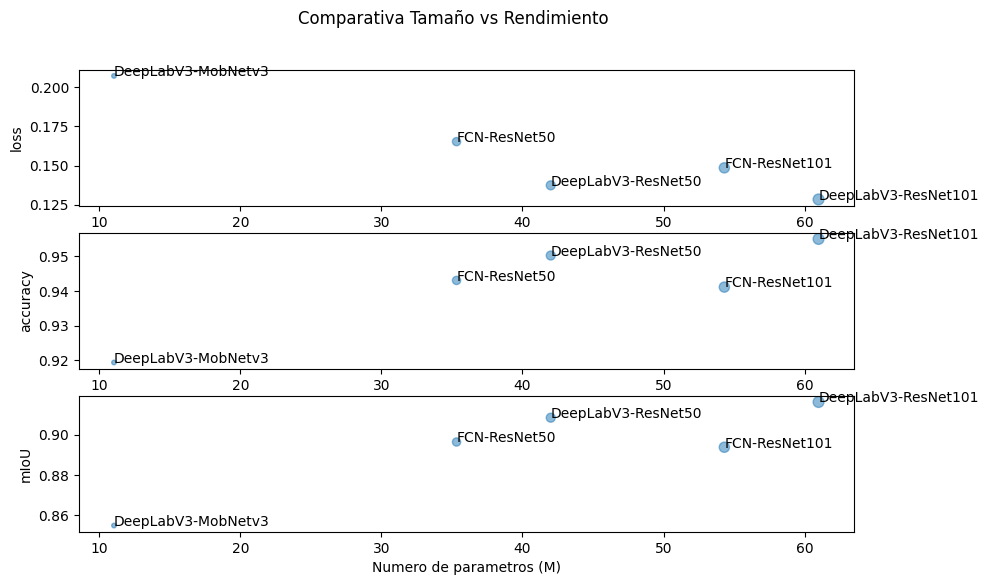

In [72]:
_ = compute_plot_metrics(models_dict, loss_fn, my_voc_dataset, device, aux=True, n_samples=25)

In [73]:
# Evalua el rendimiento de un modelo para un problema de segmentación semantica binaria
# Asume que el dataset devuelve como ground truth una mascara 2D y que el modelo devuelve como predicciones los logits
def plot_predictions(models_dict, device, aux=False, n_images=2, cmap=VOC_COLORMAP, contour=255):

    dataset = PASCALDataset(
        voc_dataset,
        transform=A.Compose([
            #A.Resize(height=250, width=500),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2()]
            ))

    original_dataset = PASCALDataset(
        voc_dataset,
        transform=A.Compose([
            #A.Resize(height=250, width=500),
            A.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0]),
            ToTensorV2()]
            ))

    images = []
    masks = []
    for i in range(len(original_dataset)):
        x, y = original_dataset.__getitem__(i)
        images.append(np.transpose(x.numpy(), (1,2,0)))
        masks.append(mask_to_rgb(y.numpy(), cmap=cmap, contour=contour))
        if i + 1 == n_images:
            break

    with torch.no_grad():

        for i in range(len(images)):

            fig, axes = plt.subplots(1, len(models_dict)+2, figsize=(15, 5))
            axes[0].imshow(images[i])
            axes[0].set_title(label="Input image", fontsize=10)
            axes[0].set(xticks=[], yticks=[])
            axes[1].imshow(masks[i])
            axes[1].set_title(label="Ground truth", fontsize=10)
            axes[1].set(xticks=[], yticks=[])

            x, _ = dataset.__getitem__(i)
            x = x.unsqueeze(0).to(device)

            for j, model_name in enumerate(models_dict):
                model = models_dict[model_name].to(device)
                model.eval()
                preds = model(x)
                if aux:
                    preds = preds["out"][0]
                preds = torch.softmax(preds, dim=0)
                preds = torch.argmax(preds, dim=0).cpu().numpy()
                pred_mask = mask_to_rgb(preds, cmap=cmap)
                axes[j+2].imshow(pred_mask)
                axes[j+2].set_title(label=model_name, fontsize=10)
                axes[j+2].set(xticks=[], yticks=[])

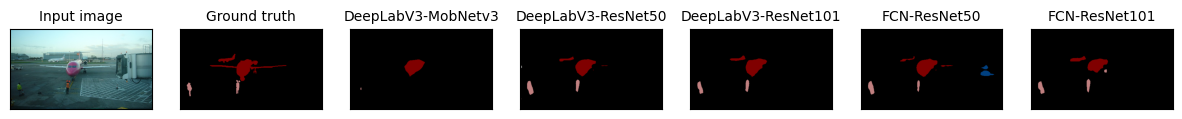

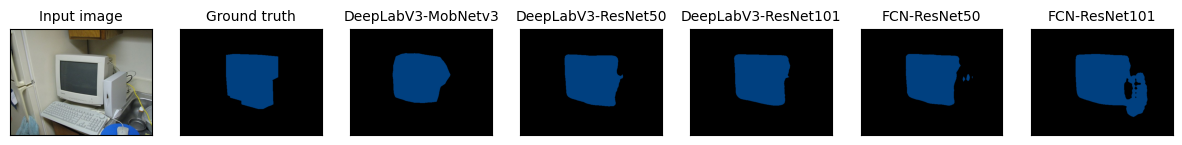

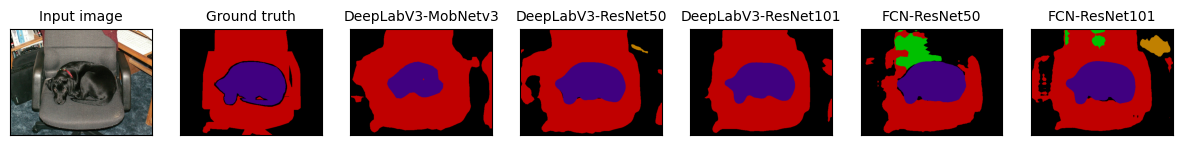

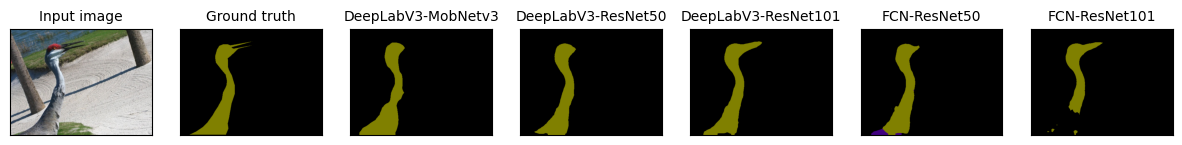

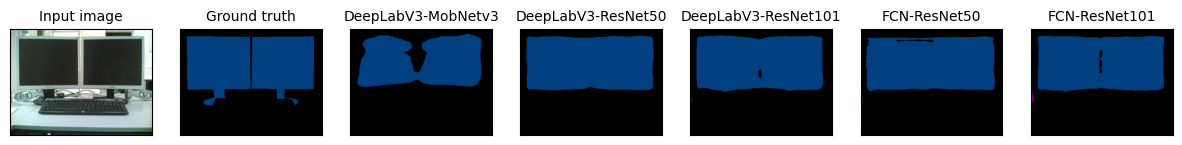

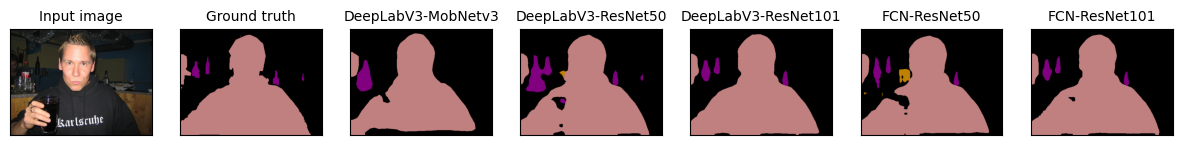

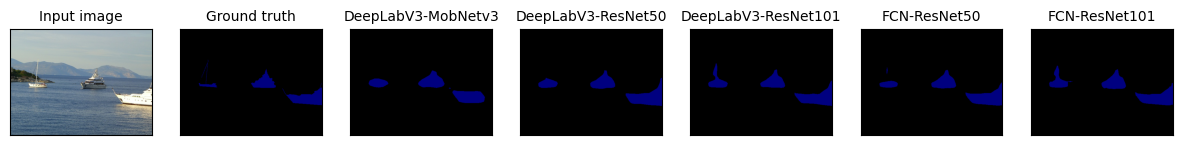

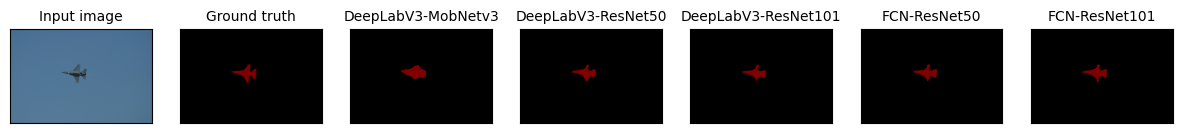

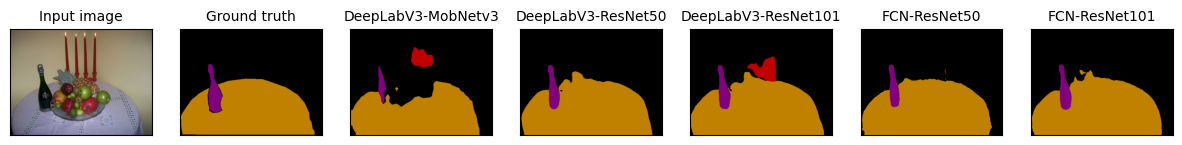

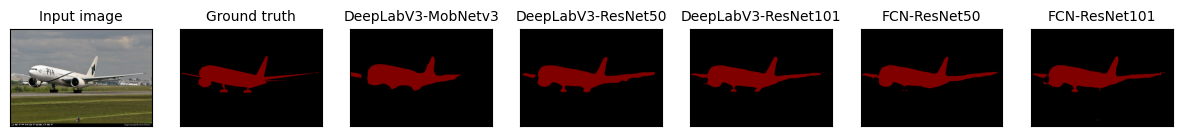

In [74]:
plot_predictions(models_dict, device, aux=True, n_images=10)